# Simple experiments on discrete-time models

In [3]:
from models_discrete import *

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [4]:
def get_x(n, d, same_hemisphere):
    """
    Generate n samples in d dimensions.

    Parameters:
    n: int, number of samples
    d: int, dimension of the samples
    same_hemisphere: bool, if True, samples are generated in the same hemisphere as the first sample

    Returns:
    x: torch.Tensor, shape (n, d), samples
    w: torch.Tensor, shape (d,), defining a hemisphere, or None
    """
    if same_hemisphere:
        w = torch.ones(d)
        w /= w.norm(dim = -1, keepdim = True)
        list_x = []
        while len(list_x) < n:
            x = torch.randn(d)
            x /= x.norm(dim = -1, keepdim = True)
            if torch.dot(x, w) > 0:
                list_x.append(x)
        x = torch.stack(list_x)
        return x, w
    else:
        x = torch.randn(n, d)
        x /= x.norm(dim = -1, keepdim = True)
        return x, None

In [7]:
class DisjointSet:
    """
    To identify the clusters.
    """
    def __init__(self, n):
        self.parent = list(range(n))
        for i in range(n):
            self.parent[i] = i
    
    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]
    
    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)
        
        if root_u != root_v:
            self.parent[root_u] = root_v

def get_clusters(model, x):
    """
    Get the clusters of the samples.

    Parameters:
    model: nn.Module, model to cluster the samples
    x: torch.Tensor, shape (n, d), samples

    Returns:
    intermediate: np.ndarray, shape (n_layers, n, d), intermediate outputs of the model
    ds_parent: list, disjoint set parent (clusters)
    """
    n = x.size(0)

    model.eval()
    intermediate = model(x)
    intermediate = torch.stack(intermediate) # (n_layers, n, d)
    intermediate = intermediate.detach().numpy()

    similarity_matrix = intermediate[-1] @ intermediate[-1].T # (n, n)
    adjacency_matrix = (similarity_matrix >= 1 - 1e-3)

    disjoint_set = DisjointSet(n)
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i, j]:
                disjoint_set.union(i, j)

    for i in range(n):
        disjoint_set.parent[i] = disjoint_set.find(i)

    return intermediate, disjoint_set.parent

In [ ]:
# Function to update the plot in 2D
def update_plot_2D(i, intermediate, w, same_hemisphere, ds_parent, title = ""):
    plt.clf()

    # Plot the samples in different colors according to the clusters
    unique_parents = list(set(ds_parent))
    for parent in unique_parents:
        indices = [idx for idx, parent_idx in enumerate(ds_parent) if parent_idx == parent]
        plt.scatter(intermediate[i][indices, 0], intermediate[i][indices, 1])
    
    # Plot the unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = np.cos(theta)
    x2 = np.sin(theta)
    plt.plot(x1, x2, 'k--', label = 'Unit circle')

    # Plot vector w
    if same_hemisphere:
        plt.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='r', label='w')

    plt.title(title + "\n" + f"Layer {i+1}")
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

    plt.gca().set_aspect('equal')

# Function to update the plot in 3D
def update_plot_3D(i, intermediate, w, same_hemisphere, ds_parent, title = ""):
    plt.clf()
    ax = plt.axes(projection='3d')

    # Plot the samples in different colors according to the clusters
    unique_parents = list(set(ds_parent))
    for parent in unique_parents:
        indices = [idx for idx, parent_idx in enumerate(ds_parent) if parent_idx == parent]
        ax.scatter(intermediate[i][indices, 0], intermediate[i][indices, 1], intermediate[i][indices, 2])
    
    # Plot the unit sphere
    phi, theta = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    ax.plot_surface(x, y, z, color = 'r', alpha = 0.2, label = 'Unit sphere')

    # Plot equator
    theta = np.linspace(0, 2*np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    z = np.zeros_like(theta)
    ax.plot(x, y, z, 'k--', label = 'Equator')
    ax.plot(z, x, y, 'k--')
    ax.plot(y, z, x, 'k--')

    # Plot vector w
    if same_hemisphere:
        ax.quiver(0, 0, 0, w[0], w[1], w[2], color = 'r', label = 'w')

    ax.set_title(title + "\n" + f"Layer {i+1}")
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)

    ax.set_box_aspect([1, 1 , 1])

## In dimension 2

Here we initialize a model for $d = 2$, and look at the dynamics on the circle.

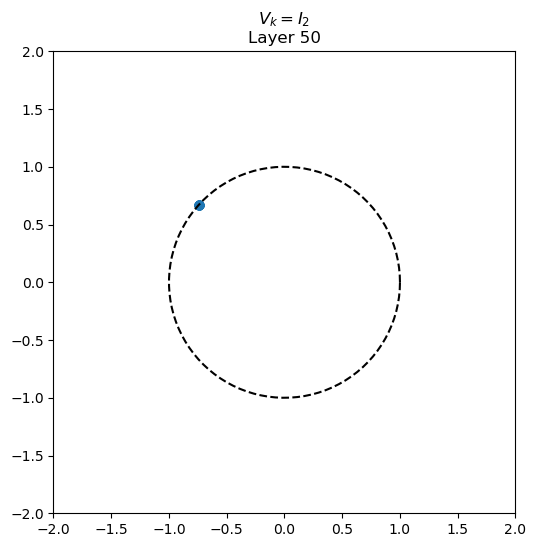

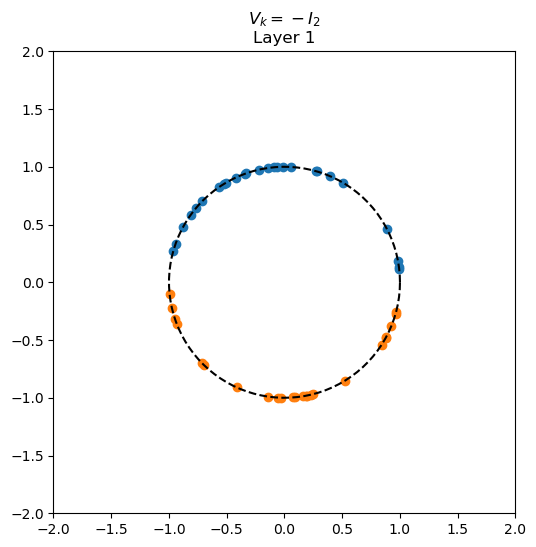

In [10]:
# GIF to see in 2D

d = 2
n_layers = 50
beta = 1.
n = 50

same_hemisphere = False # If True, the points are sampled in the same hemisphere defined by w. If False, they are sampled uniformly.

x, w = get_x(n, d, same_hemisphere)

# V_k = alpha I_d, alpha > 0
model = CustomTransformer(d, n_layers, beta = beta, store_intermediate = True, share = True, value = "id", alpha = 1.)
intermediate, ds_parent = get_clusters(model, x)

fig, ax = plt.subplots(figsize = (8, 6))
title = r"$V_k = I_2$"
ani = FuncAnimation(fig, lambda i: update_plot_2D(i, intermediate, w, same_hemisphere, ds_parent, title),
                    frames = len(intermediate), interval = 100)

ani.save('dynamics_2d_identity.gif', writer = 'pillow', fps = 6)

# V_k = -alpha I_d, alpha > 0
model = CustomTransformer(d, n_layers, beta = beta, store_intermediate = True, share = True, value = "id", alpha = -1.)
intermediate, ds_parent = get_clusters(model, x)

fig, ax = plt.subplots(figsize = (8, 6))
title = r"$V_k = -I_2$"
ani = FuncAnimation(fig, lambda i: update_plot_2D(i, intermediate, w, same_hemisphere, ds_parent, title),
                    frames = len(intermediate), interval = 100)

ani.save('dynamics_2d_minus_identity.gif', writer = 'pillow', fps = 6)

## In dimension 3

Here we initialize a model for $d = 3$, and look at the dynamics on the circle.

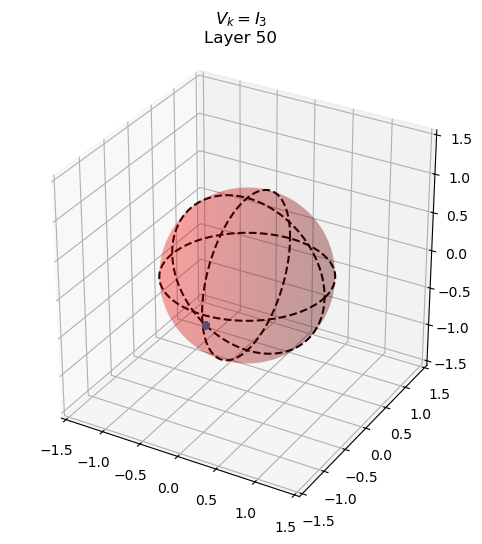

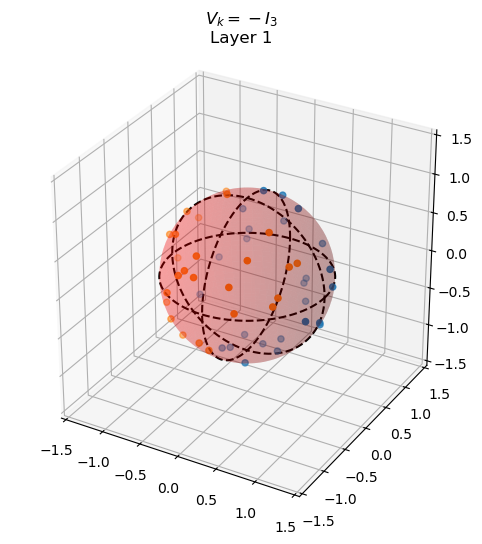

In [11]:
# GIF to see in 3D

d = 3
n_layers = 50
beta = 1.
n = 50

same_hemisphere = False

x, w = get_x(n, d, same_hemisphere)

# V_k = alpha I_d, alpha > 0
model = CustomTransformer(d, n_layers, beta = beta, store_intermediate = True, share = True, value = "id", alpha = 1.)
intermediate, ds_parent = get_clusters(model, x)

fig, ax = plt.subplots(figsize = (8, 6))
title = r"$V_k = I_3$"
ani = FuncAnimation(fig, lambda i: update_plot_3D(i, intermediate, w, same_hemisphere, ds_parent, title),
                    frames = len(intermediate), interval = 100)

ani.save('dynamics_3d_identity.gif', writer = 'pillow', fps = 6)

# V_k = -alpha I_d, alpha > 0
model = CustomTransformer(d, n_layers, beta = beta, store_intermediate = True, share = True, value = "id", alpha = -1.)
intermediate, ds_parent = get_clusters(model, x)

fig, ax = plt.subplots(figsize = (8, 6))
title = r"$V_k = -I_3$"
ani = FuncAnimation(fig, lambda i: update_plot_3D(i, intermediate, w, same_hemisphere, ds_parent, title),
                    frames = len(intermediate), interval = 100)

ani.save('dynamics_3d_minus_identity.gif', writer = 'pillow', fps = 6)